# ST446 - Distributed Computing for Big Data - Lent Term 2020-2021

## Homework 1: Spark RDDs, Spark SQL and Hive

---

## Instructions:

**Deadline**: February 26th, 2021, 7pm London time.

**Datasets**: All the required datasets are available for download from here:

https://www.dropbox.com/sh/89xbpcjl4oq0j4w/AACrbtUzm3oCW1OcpL7BasRfa?dl=0
(in the respective sub-directories).

Please make sure that you document your work appropriately. If you get stuck somewhere, make sure to give the other parts a try.


## A. Spark RDDs (30 points)

We continue to analyse the DBLP dataset available in the file `author-large.txt`. This time, we want to find the top 10 pairs of authors who published the largest number of papers together (with possible other collaborators). For example, if authors $a$, $b$ and $c$ published a paper with title $t$, then this contributes one joint publication for each author pair ($a$,$b$), ($b$,$c$) and ($a$,$c$). Use the first column of the input data for the author names and use the third column of the input data for the publication title. 

You need to solve this task by using RDD operations in PySpark like those in `pyspark_rdd.ipynb` in Week 3 of the course and the [Spark RDD documentation]( http://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD). You can run your code on your laptop or GCP. Please make sure to give us all your code and document what you have done outside of the notebook, for example using terminal in- and output or screenshots. **Please, pay attention to have the terminal input/output and screenshot files stored in your repository and properly linked and displayed in your notebook.**

*Please make sure to delete you dataproc clusters and buckets afterwards.*

#### My Solution

Before getting started, from my local CLI, I create a bucket on the GCP and start a Dataproc cluster with the following shell commands and specifications.

```shell
# ON MY LOCAL CLI:
# make bucket
gsutil mb -l europe-west2 -p st446-lse-2021 gs://st446-mybucket

# start dataproc cluster
gcloud beta dataproc clusters create st446-mycluster --enable-component-gateway --bucket st446-mybucket 
    --region europe-west2 --zone europe-west2-c --master-machine-type n1-standard-4 --master-boot-disk-size 500 
    --num-workers 2 --worker-machine-type n1-standard-4 --worker-boot-disk-size 500 --image-version 1.5-debian10 
    --optional-components ANACONDA,JUPYTER --project st446-lse-2021
```

To download the data and copy it onto my GCP bucket, I run the commands below in the CLI on the master VM. All shell commands used (together with those needed for part C) are in the sh file *gcp_commands.sh*, which is available in this repository. However, I also document all the commands I use here in the notebook.


```shell
# ON THE MASTER VM'S CLI:
# make directory
mkdir -p data/dblp

# download the data
wget -P data/dblp https://www.dropbox.com/sh/89xbpcjl4oq0j4w/AABrktOFt6ZSD4iRpjERe5Nca/dblp/author-large.txt
gsutil cp data/dblp/author-large.txt gs://st446-mybucket/data/ # copy to bucket
```

In [1]:
# import additional library I use
import itertools

# connect to data file
authors = sc.textFile('gs://st446-mybucket/data/author-large.txt')

# a first look at the data structure
# initially, each line is just a single string
authors.take(3)

['Jurgen Annevelink\tModern Database Systems\tObject SQL - A Language for the Design and Implementation of Object Databases.\t1995',
 'Rafiul Ahad\tModern Database Systems\tObject SQL - A Language for the Design and Implementation of Object Databases.\t1995',
 'Amelia Carlson\tModern Database Systems\tObject SQL - A Language for the Design and Implementation of Object Databases.\t1995']

To find the top 10 pairs of authors who published the largest number of papers together, I take the following 8 steps:

1. split each line at tabs ("\t") (_map_ function)
2. create a (key, value) structure with the publication's title as the key and the author's name as its value (_map_ function)
3. apply _groupByKey_ to obtain a (key, value) structure where each key is still the publication's title but its value now is a list of all authors of that paper
4. sort every list to make sure that the following steps are correct; this is important because every pair of authors (see next step) should be ordered lexicographically (_map_ function)
5. next, get each combination of authors as a tuple by using a custom function I call _combinations_ (see below, I also show an example); in this step, also get rid of the publication titles since we do not need them any more from here on (_flatMap_ function)
6. create a new (key, value) structure with each pair of authors as a key and 1 as its value
7. use countByKey to get a dictionary of the counts for each pair of authors
8. finally, sort that dictionary by its values and show the 10 pairs of authors who have the most publications together

Steps 7 and 8 can alternatively be done by using an explicit reduce function and sorting the resulting (key, value) using another Spark transformation. I try both methods to see which one is faster.

In [2]:
# steps 1 to 4
aggregated = authors.map(lambda line: line.split('\t')).map(lambda l: (l[2], l[0])).groupByKey().mapValues(sorted)
aggregated.take(3)

[('OQL[C++]: Extending C++ with an Object Query Capability.',
  ['Jos A. Blakeley']),
 ('Active Database Systems.',
  ['Eric N. Hanson', 'Jennifer Widom', 'Umeshwar Dayal']),
 ('Where Object-Oriented DBMSs Should Do Better: A Critique Based on Early Experiences.',
  ['Angelika Kotz Dittrich', 'Klaus R. Dittrich'])]

In [3]:
# custom function used to transform RDD (step 5)
def combinations(row):
    # takes in a row consiting of a key (title) and value (list of authors)
    # returns a list of each combination of authors, discarding the title
    # if there is only one author, returns an empty list
    l = row[1]
    return [v for v in itertools.combinations(l, 2)]

# example
combinations(('k1', ['v1', 'v2', 'v3']))

[('v1', 'v2'), ('v1', 'v3'), ('v2', 'v3')]

In [4]:
# steps 5 and 6
keyvalue = aggregated.flatMap(combinations).map(lambda pair: (pair, 1))

In [5]:
%%time
# steps 7 and 8
counts = keyvalue.countByKey() # countByKey is an action and returns a dictionary
sorted(counts.items(), key=lambda x:x[1], reverse=True)[:10]

CPU times: user 2.44 s, sys: 505 ms, total: 2.95 s
Wall time: 9.06 s


[(('Irith Pomeranz', 'Sudhakar M. Reddy'), 249),
 (('Amr El Abbadi', 'Divyakant Agrawal'), 161),
 (('Makoto Takizawa', 'Tomoya Enokido'), 141),
 (('Didier Dubois', 'Henri Prade'), 122),
 (('Elizabeth Chang', 'Tharam S. Dillon'), 118),
 (('Hyun-Sung Kim', 'Kee-Young Yoo'), 111),
 (('Mary Jane Irwin', 'Narayanan Vijaykrishnan'), 107),
 (('Mahmut T. Kandemir', 'Mary Jane Irwin'), 100),
 (('Giuseppe De Giacomo', 'Maurizio Lenzerini'), 99),
 (('Chun Chen', 'Jiajun Bu'), 99)]

In [6]:
%%time
# again steps 7 and 8, but this time, use explicit reduce function and let spark do the sorting
keyvalue.reduceByKey(lambda a,b: a+b).sortBy(lambda a: a[1], False).take(10)

CPU times: user 50.9 ms, sys: 3.77 ms, total: 54.7 ms
Wall time: 21.2 s


[(('Irith Pomeranz', 'Sudhakar M. Reddy'), 249),
 (('Amr El Abbadi', 'Divyakant Agrawal'), 161),
 (('Makoto Takizawa', 'Tomoya Enokido'), 141),
 (('Didier Dubois', 'Henri Prade'), 122),
 (('Elizabeth Chang', 'Tharam S. Dillon'), 118),
 (('Hyun-Sung Kim', 'Kee-Young Yoo'), 111),
 (('Mary Jane Irwin', 'Narayanan Vijaykrishnan'), 107),
 (('Mahmut T. Kandemir', 'Mary Jane Irwin'), 100),
 (('Chun Chen', 'Jiajun Bu'), 99),
 (('Giuseppe De Giacomo', 'Maurizio Lenzerini'), 99)]

Using countByKey with subsequent local sorting of the dictionary appears to be faster in this case than using the explicit reduce step with sorting in Spark.

**Result**: The top pair is (Pomeranz, Reddy) with 249 publications together. 

## B. Spark SQL (30 points)

Do the same as in problem A, but this time use the Spark SQL API, which we covered in Week 4. You may find useful to consult 'Querying with Spark SQL' in `spark-dataframe-sql.ipynb` of Week 4 class and the [Spark SQL documentation](http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html).

In [7]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

# define a schema for the dataframe
schema = StructType([
    StructField("author", StringType()),
    StructField("journal", StringType()),
    StructField("title", StringType()),
    StructField("year", IntegerType())])

# create dataframe directly from the tsv file
authorsDF = spark.read.csv('gs://st446-mybucket/data/author-large.txt', schema=schema, header='false', sep='\t')
authorsDF

# create a temporary view for SQL queries
authorsDF.createOrReplaceTempView("authors")

# print the table schema
authorsDF.printSchema()

root
 |-- author: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- title: string (nullable = true)
 |-- year: integer (nullable = true)



An SQL query that shows the 10 pairs of authors who published the most papers in tandem is shown below. The main step here is the **self join**, i.e. a join of the _authors_ table with itself on the _title_ column. As a result, each new row contains a pair of authors who published a paper together. 

Since this would also lead to rows that have the same author twice as well as rows that have not only (author1, author2) but also (author2, author1), I ensure that `author1 < author2` (string inequalities are evaluated lexicographically). 

Finally, I use _group by_ and _order by count_ to get the top 10 pairs.

In [9]:
%%time
query = """
    SELECT a1.author as authorA, a2.author as authorB, COUNT(*) as counts
    FROM authors a1
    JOIN authors a2
    ON a1.title = a2.title
    WHERE a1.author < a2.author
    GROUP BY a1.author, a2.author
    ORDER BY COUNT(*) DESC
    LIMIT 10
    """

spark.sql(query).show()

+-------------------+--------------------+------+
|            authorA|             authorB|counts|
+-------------------+--------------------+------+
|     Irith Pomeranz|   Sudhakar M. Reddy|   249|
|      Amr El Abbadi|   Divyakant Agrawal|   161|
|    Makoto Takizawa|      Tomoya Enokido|   141|
|      Didier Dubois|         Henri Prade|   122|
|    Elizabeth Chang|    Tharam S. Dillon|   118|
|      Hyun-Sung Kim|       Kee-Young Yoo|   111|
|    Mary Jane Irwin|Narayanan Vijaykr...|   107|
| Mahmut T. Kandemir|     Mary Jane Irwin|   100|
|          Chun Chen|           Jiajun Bu|    99|
|Giuseppe De Giacomo|  Maurizio Lenzerini|    99|
+-------------------+--------------------+------+

CPU times: user 4.27 ms, sys: 809 µs, total: 5.08 ms
Wall time: 11.8 s


Spark DataFrames can not only be processed by SQL queries, but also in a functional programming way, resembling RDD operations to some extent. The "query" (see below) is essentially equivalent to the SQL query, but not quite as elegant in my view. I include both methods here as I wanted to get to know both. In terms of speed, they performed similarly. In fact, spark emphasizes that no matter which API is used, the backend operations are the same (for the same query).

In [10]:
%%time
a1 = authorsDF.alias("a1")
a2 = authorsDF.alias("a2")

joined_df = a1.join(a2, "title")
pairs = joined_df.select(col("a1.author").alias("authorA"), col("a2.author").alias("authorB"))
counts = pairs.where(col("a1.author")<col("a2.author")).groupBy("authorA", "authorB").count().orderBy("count", ascending=False)
counts.show(10)

+-------------------+--------------------+-----+
|            authorA|             authorB|count|
+-------------------+--------------------+-----+
|     Irith Pomeranz|   Sudhakar M. Reddy|  249|
|      Amr El Abbadi|   Divyakant Agrawal|  161|
|    Makoto Takizawa|      Tomoya Enokido|  141|
|      Didier Dubois|         Henri Prade|  122|
|    Elizabeth Chang|    Tharam S. Dillon|  118|
|      Hyun-Sung Kim|       Kee-Young Yoo|  111|
|    Mary Jane Irwin|Narayanan Vijaykr...|  107|
| Mahmut T. Kandemir|     Mary Jane Irwin|  100|
|Giuseppe De Giacomo|  Maurizio Lenzerini|   99|
|          Chun Chen|           Jiajun Bu|   99|
+-------------------+--------------------+-----+
only showing top 10 rows

CPU times: user 94.3 ms, sys: 12.4 ms, total: 107 ms
Wall time: 8.58 s


## C. Hive (40 points)

In this part we are going to use the Yelp data available in the following JSON file `Yelp/yelp_academic_dataset_user.json`. You may complete this task by using either Hive installed on your laptop or using Hive on Google Cloud Platform. Please complete the following steps:

_(Here, it is particularly important that you find a suitable way to document your work appropriately.)_

### 1. Load data into a Hive table

Create a Hive table and load the input data into this table.

Please describe any commmands that you run in a command line interface, provide all the code that you wrote and ran. For example, this may include any commands run in a terminal, Hive script files (\*.sql), and screenshots (if, for example, you used Google Cloud Platform through the browser interface). See the class examples for reference.

Note:
* The dataset is in JSON format whereas in the class the datasets were in XML or TXT format. You will need to figure out (look up) how to load data from a JSON file to a Hive table. 
* You will need to infer the schema by looking at the data. 

Hints: 

* Some of the columns are of array type. For example, you should use array&lt;STRING&gt; for the $friends$ column.
* The size of the dataset is large (about 1GB). You may want to create a smaller dataset first and work with this smaller dataset until you develop and test your code, and then apply it on the original dataset.

### 2. Simple queries

Having created the Hive table and loaded the data into it, write and execute queries to:

i. retrieve the schema;

ii. show the number of rows in the table;

iii. select top 10 users who have provided the largest number of reviews (the output should consist of the user name and the number of reviews of the users).

For all the queries, please show both the commands you used and the output. You may copy and paste the commands that you run and the outputs, or provide screenshots. **Please, pay attention to have the terminal input/output and screenshot files stored in your repository and properly linked and displayed in your notebook.**

### My Solution for C1: Load data into a Hive table

First, I upload the files

* **gcp_commands.sh** and 
* **load_yelp_hive.sql** 

from my personal laptop onto the virtual machine using the "Upload file" functionality of the master VM's browser CLI.

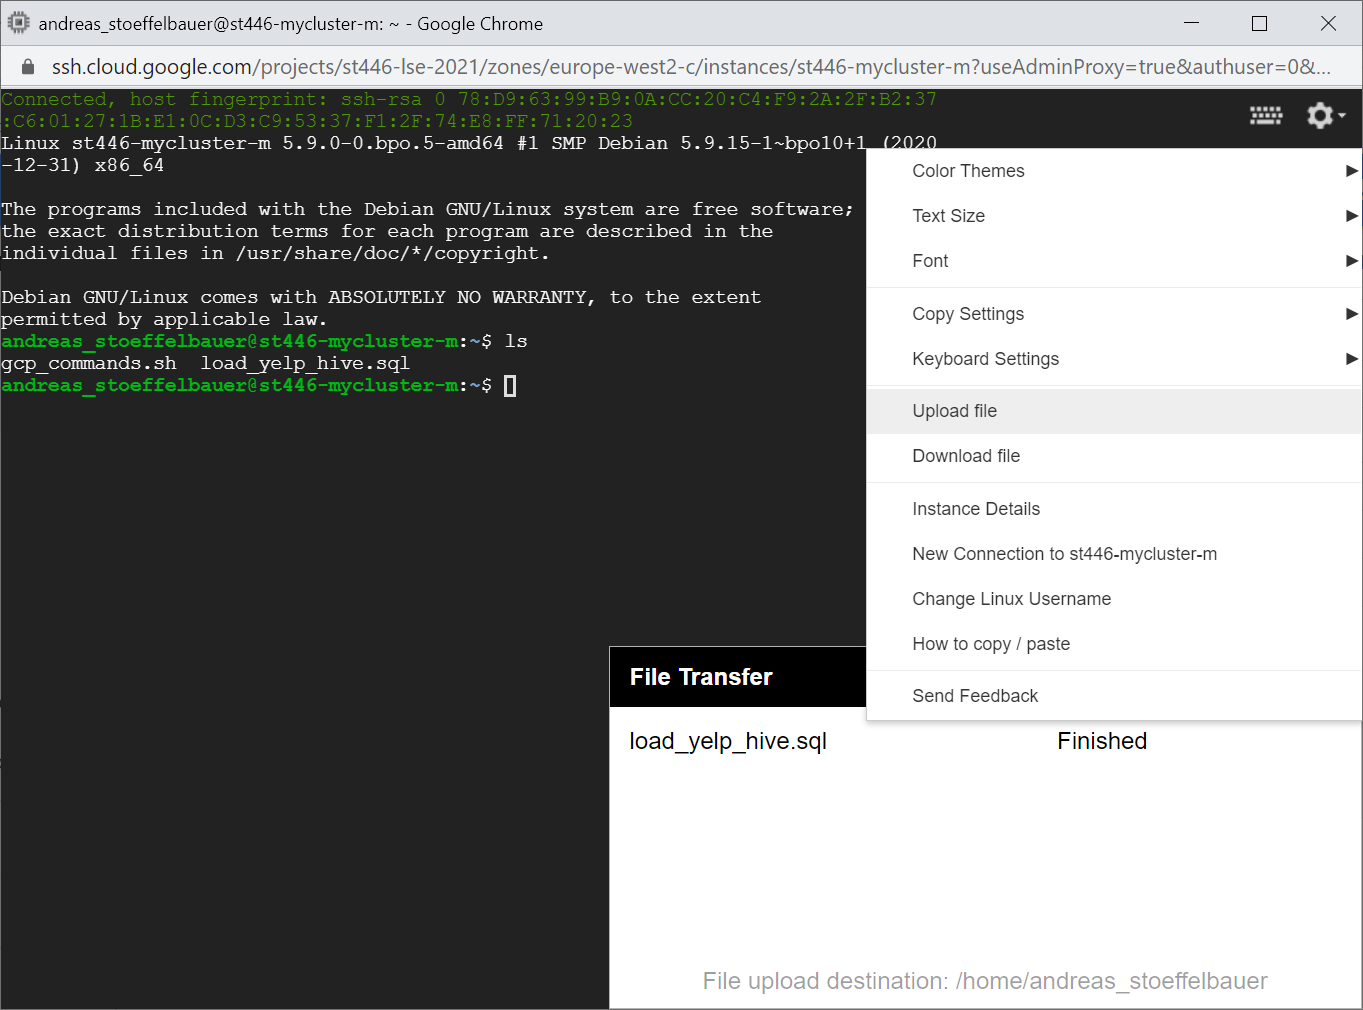

In [2]:
from IPython.display import Image
Image(filename='img/upload_cli.PNG')

Next, I run *gcp_commands.sh*. The file simply executes some basic commands to make new directories and download the yelp data (json file) onto the VM. The commands are the following:

```shell
# ON THE MASTER VM'S CLI
# make a directory
mkdir -P data/yelp

# download the data into the directory
wget -P data/yelp https://www.dropbox.com/sh/89xbpcjl4oq0j4w/AAC4_qW_wKyGIXXYZOwZC-Wia/Yelp/yelp_academic_dataset_user.json

```

Finally, to load the json data into a hive table, I execute *load_yelp_hive.sql*, which can be found in this repository as well. 

```shell
hive -f load_yelp_hive.sql
```

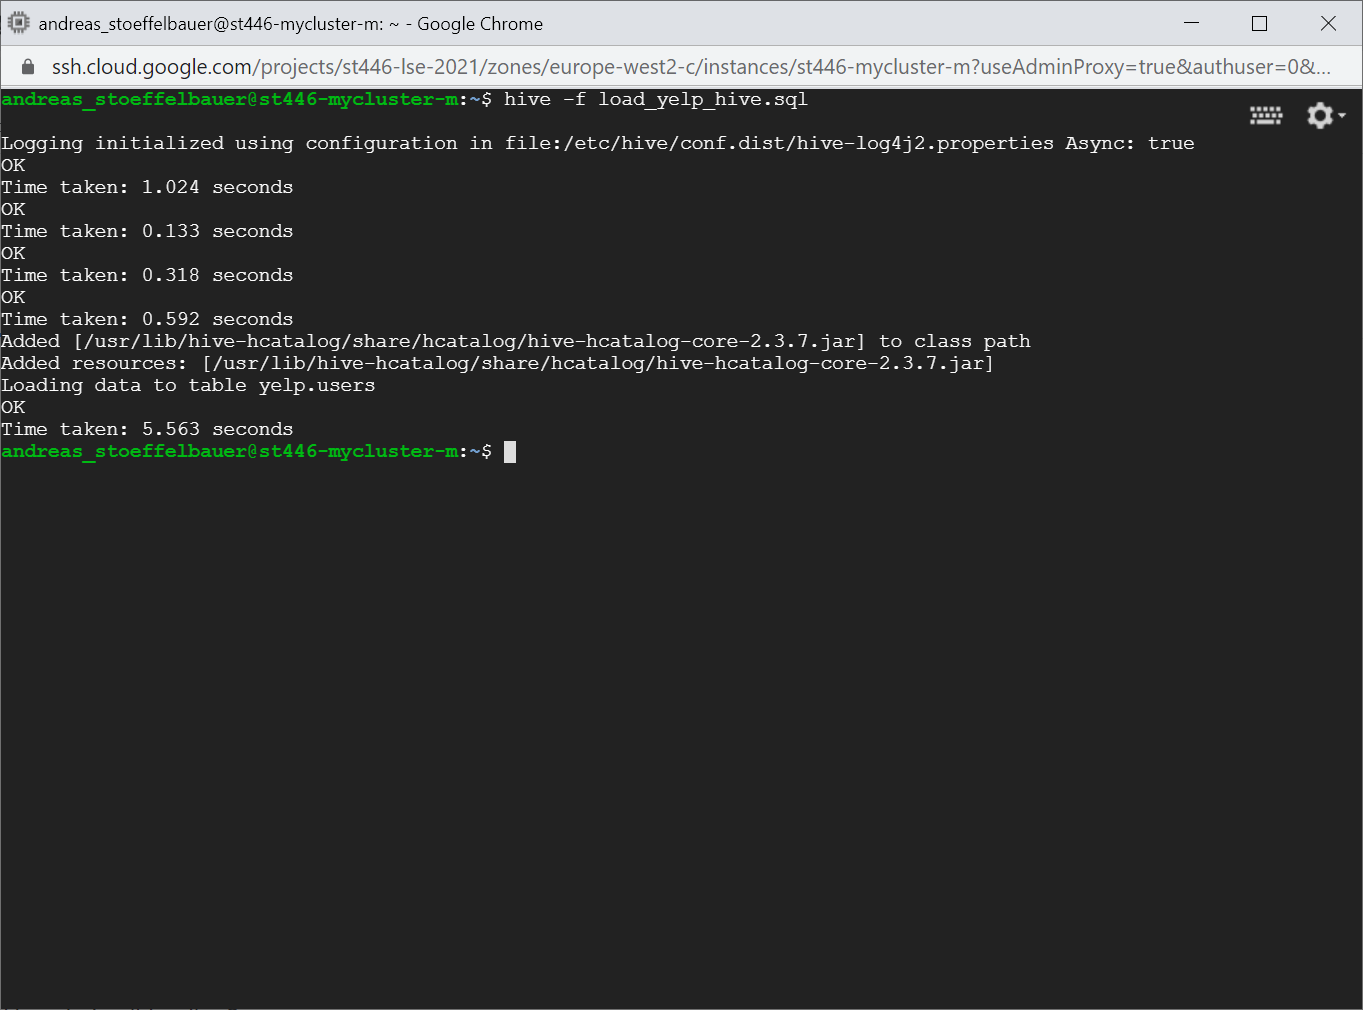

In [3]:
Image(filename='img/hive-loaddata.PNG')

### My Solution for C2: Simple queries

I run my queries from within the master's shell. Because the Hive CLI will be deprecated in the future, it is recommended to use *Beeline*, the new CLI for Hive. However, I stick to the Hive CLI for this exercise as it is the one that was used in our classes, and in addition, I found it to be more appealing to use (for example, it provides useful information while processing a query, which Beeline does not).

To open a Hive session on the GCP, run
```sql
hive
```

Once inside the Hive session, it is necessary to point the session to the following jar file.

```sql
ADD JAR /usr/lib/hive-hcatalog/share/hcatalog/hive-hcatalog-core-2.3.7.jar;
```

i. Now that the data has been loaded into a hive table (in part C1), to retrieve the schema, simply run
```sql
USE yelp;  
DESCRIBE users;
```

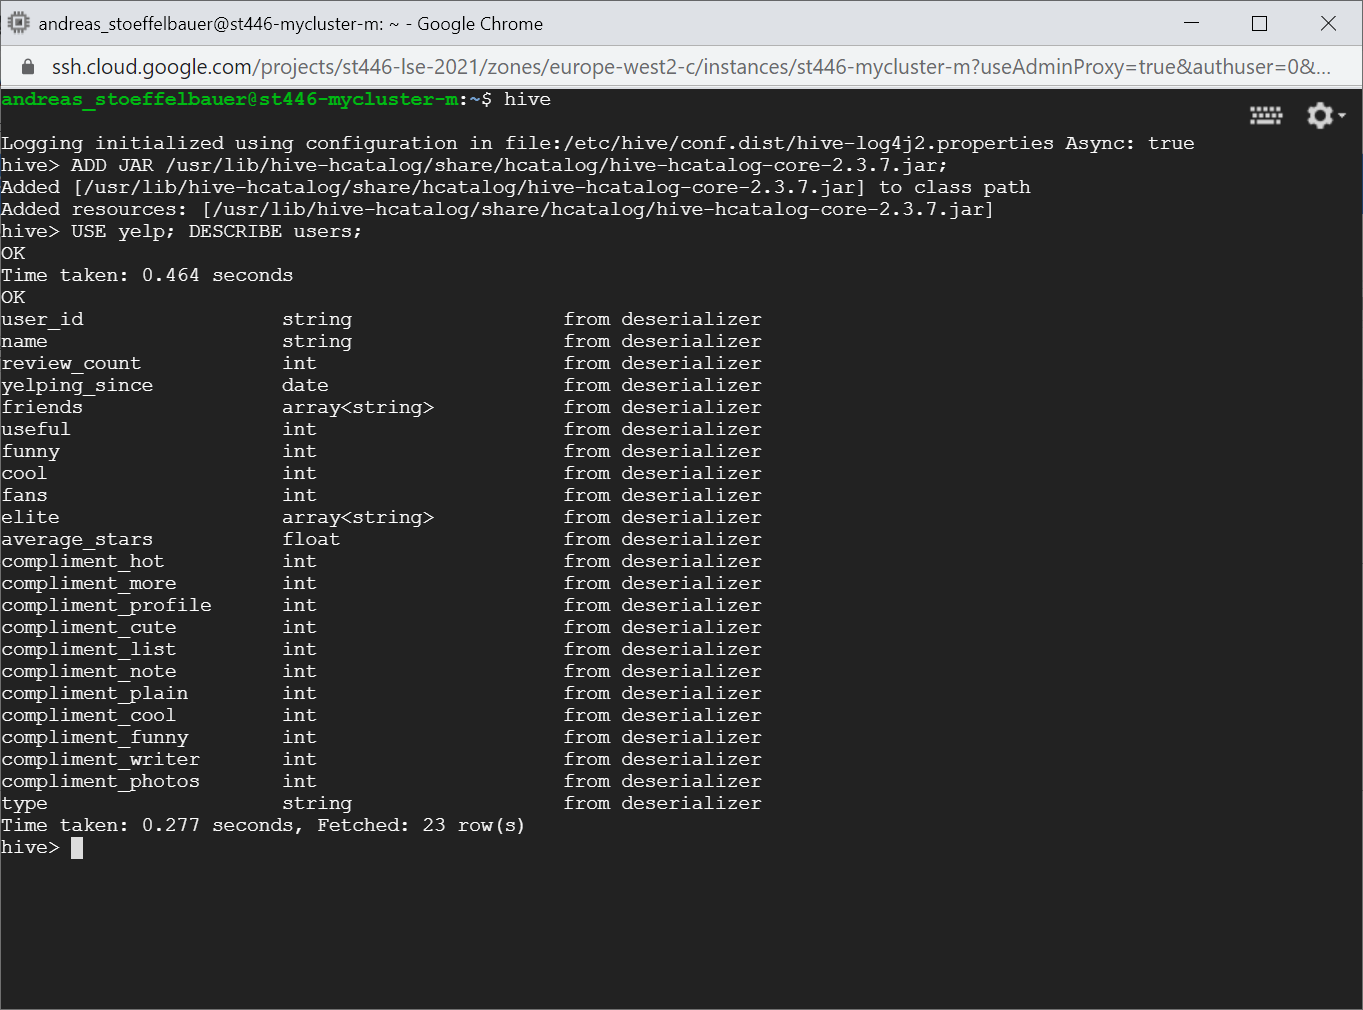

In [4]:
Image(filename='img/hive-describe.PNG')

ii. To get a row count, run
```sql
SELECT count(*) FROM users;
```

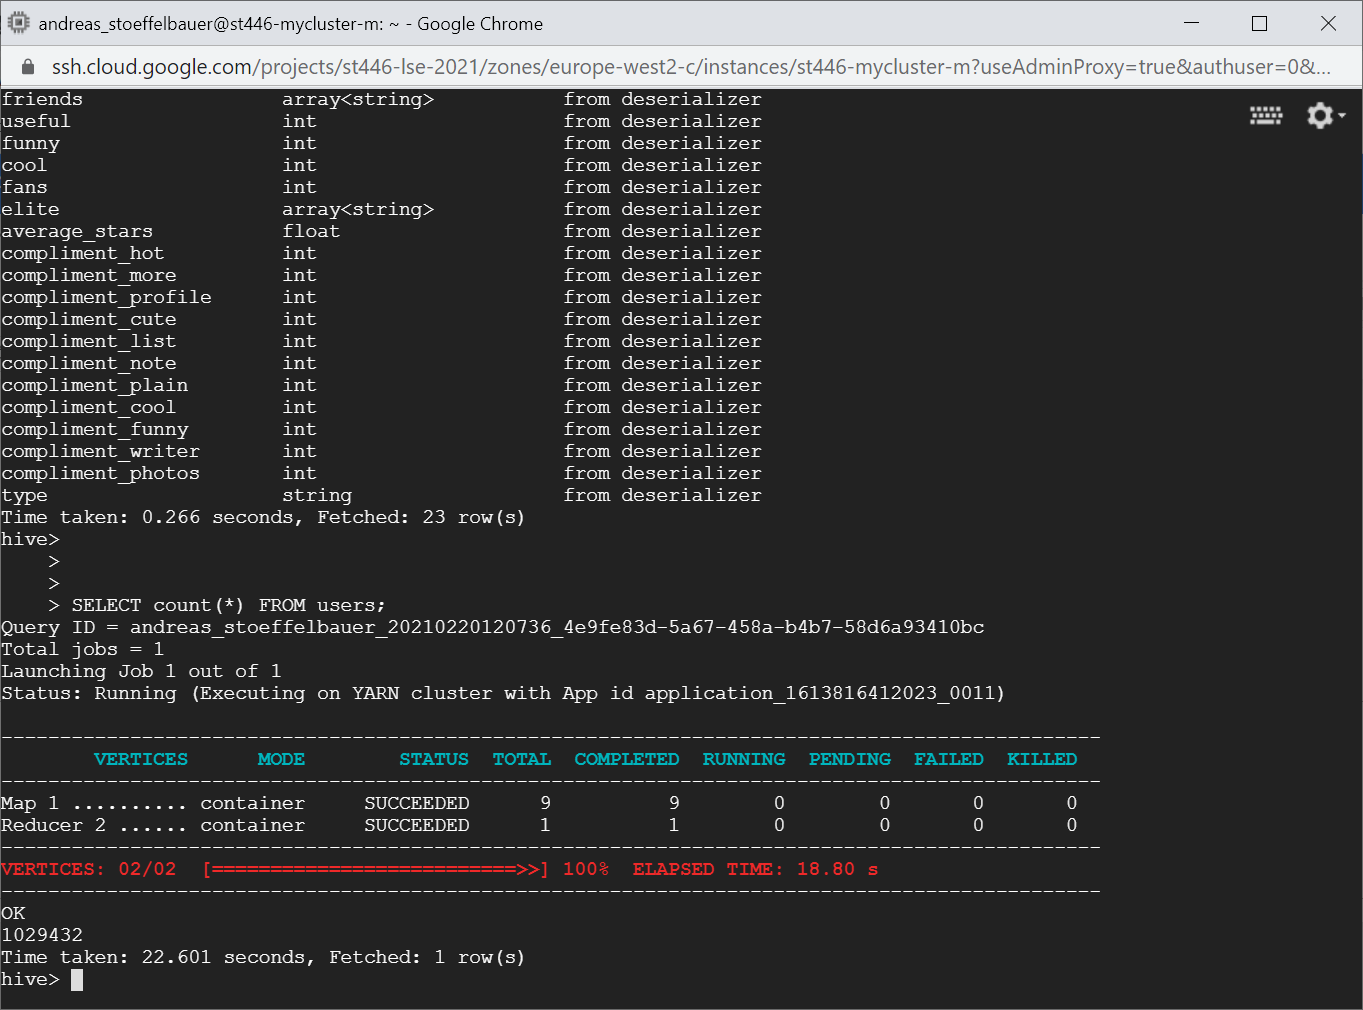

In [5]:
Image(filename='img/hive-rowcount.PNG')

iii. Finally, to find the most active reviewers, run
```sql
SELECT name, review_count 
FROM users 
ORDER BY review_count DESC 
LIMIT 10;
```

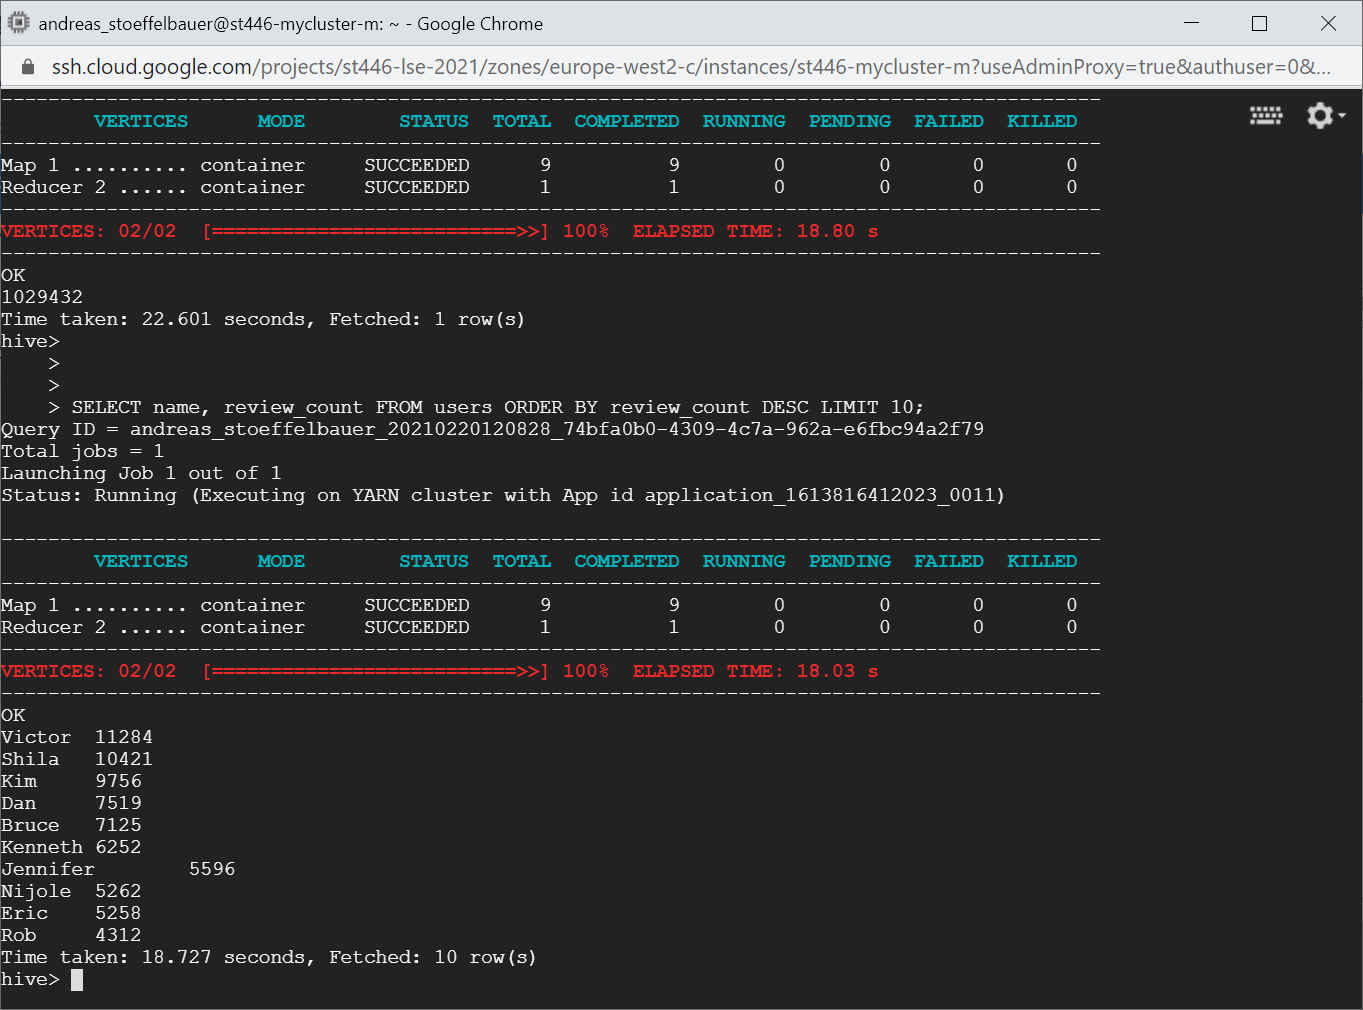

In [6]:
Image(filename='img/hive-mostreviews.PNG')

## Marking scheme

| **Problem breakdown** | **Max marks** | 
|-------------------|---------------|
| A1-i loading data into RDD	|	10 |	
| A1-ii query correctness 	|	10 |
| A1-iii quality of code and presentation    |	10  |
| B1-i creating and loading data into a table	|	10 |
| B1-ii query expression correctness    |	10 |
| B1-iii quality of code and presentation   | 10 |
| C1 loading data into Hive    |   10 |
| C2-i retrieving the schema | 10 |
| C2-ii show number of rows | 10 |
| C2-iii selecting top 10 users | 10 |
| | Total 100 |
